# Goals
Build an image classifier that detects happy images and sad images using Neural Networks

### Dependencies


In [210]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

### Remove dodgy images

In [211]:
import cv2
import imghdr

In [212]:
data_dir = 'data'
image_exts = ['jpeg','jpg','bmp','png']

In [213]:
for image_class in os.listdir(data_dir): #loop into the folder data_dir and open the folders in it (happy and sad)
    for image in os.listdir(os.path.join(data_dir,image_class)): #get every single image in happy and sad
        image_path = os.path.join(data_dir,image_class,image) #get image path
        try:
            img = cv2.imread(image_path) #converts the image into a numpy array
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print(f'Image not in ex list {image_path}')
                os.remove(image_path)
        except Exception as e:
            print(f'Issue with image {image_path}')

### Load data

In [214]:
data = tf.keras.utils.image_dataset_from_directory('data') # load the dataset from the happy and sad files, builds data pipeline

Found 170 files belonging to 2 classes.


In [215]:
data_iterator = data.as_numpy_iterator() #allows to access data pipeline

In [216]:
batch = data_iterator.next() #grabs one batch from data pipeline

In [217]:
#Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [218]:
#Labels
batch[1]

array([1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0])

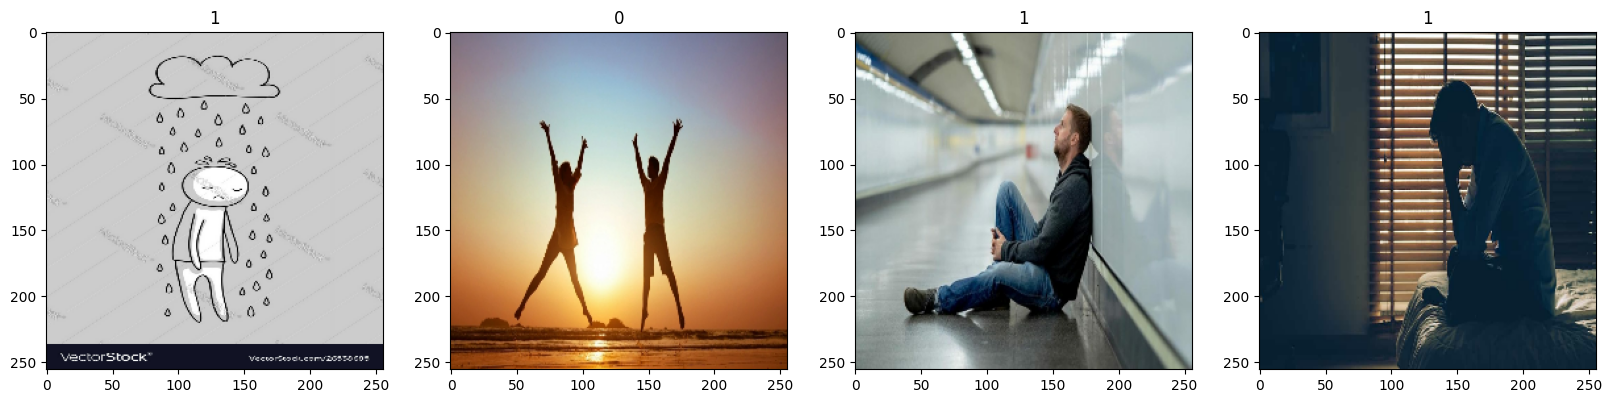

In [219]:
#Understand which class is happy or sad
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

We can understand that 1 is for sad people and 0 is for happy people

### Data Preprocessing

Scale the data

In [220]:
data = data.map(lambda x,y: (x/255,y)) # allows to scale the data in the pipeline, sice the max value of data[0] is 255

Split the data into train, cv and test

In [221]:
len(data)

6

In [222]:
train_size = int(len(data)*.7) #70% goes to train set
cv_size = int(len(data)*.2) #20% goes to train set
test_size = int(len(data)*.1)+1 #10% goes to train set

In [223]:
train = data.take(train_size)
cv = data.skip(train_size).take(cv_size)
test = data.skip(train_size+cv_size).take(test_size)

In [224]:
len(train)

4

### Build the learning model

In [225]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [226]:
model = Sequential([
    #
    Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (256,256,3)),
    MaxPooling2D(),

    Conv2D(32, (3,3), 1, activation = 'relu', input_shape = (256,256,3)),
    MaxPooling2D(),

    Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (256,256,3)),
    MaxPooling2D(),

    Flatten(),
    Dense(256,activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

In [227]:
model.compile('adam',loss=tf.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [228]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 16)      

### Train the model

In [229]:
logdir = 'logs'

In [230]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [231]:
hist = model.fit(train, epochs=20, validation_data=cv, callbacks=[tensorboard_callback])

Epoch 1/20


4/4 [==============================] - 5s 1s/step - loss: 1.2954 - accuracy: 0.4609 - val_loss: 0.6097 - val_accuracy: 0.6562
Epoch 2/20
4/4 [==============================] - 4s 919ms/step - loss: 0.7532 - accuracy: 0.5625 - val_loss: 0.7282 - val_accuracy: 0.4375
Epoch 3/20
4/4 [==============================] - 4s 902ms/step - loss: 0.6487 - accuracy: 0.5625 - val_loss: 0.6759 - val_accuracy: 0.6562
Epoch 4/20
4/4 [==============================] - 5s 1s/step - loss: 0.6682 - accuracy: 0.6484 - val_loss: 0.6454 - val_accuracy: 0.7812
Epoch 5/20
4/4 [==============================] - 4s 960ms/step - loss: 0.6029 - accuracy: 0.7266 - val_loss: 0.6492 - val_accuracy: 0.5625
Epoch 6/20
4/4 [==============================] - 4s 900ms/step - loss: 0.5865 - accuracy: 0.6719 - val_loss: 0.5373 - val_accuracy: 0.8750
Epoch 7/20
4/4 [==============================] - 4s 916ms/step - loss: 0.4917 - accuracy: 0.7812 - val_loss: 0.4227 - val_accuracy: 0.9062
Epoch 8/20
4/4 [=====================

### Plot performance

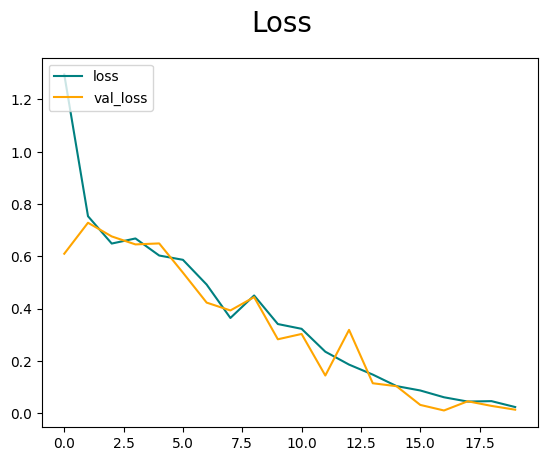

In [232]:
fig = plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize = 20)
plt.legend(loc="upper left")
plt.show()

### Plot accuracy

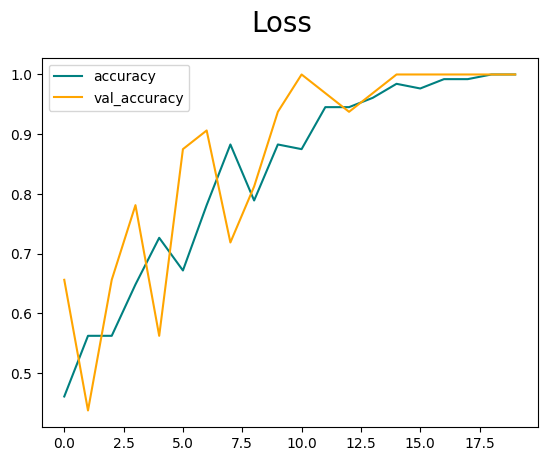

In [233]:
fig = plt.figure()
plt.plot(hist.history['accuracy'],color='teal',label='accuracy')
plt.plot(hist.history['val_accuracy'],color='orange',label='val_accuracy')
fig.suptitle('Loss',fontsize = 20)
plt.legend(loc="upper left")
plt.show()

### Evaluate performance

In [234]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [235]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [236]:
for batch in test.as_numpy_iterator():
    X,y = batch
    yhat = model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

1/1 [==============================] - 0s 121ms/step


In [237]:
print(f"Precision: {pre.result().numpy()}")
print(f"Recall: {re.result().numpy()}")
print(f"Accuracy: {acc.result().numpy()}")

Precision: 1.0
Recall: 1.0
Accuracy: 1.0


### Testing the model

In [238]:
import cv2

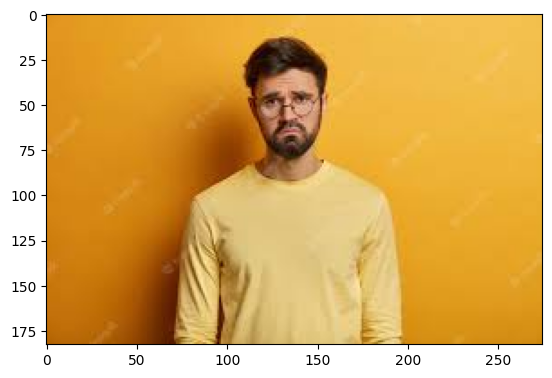

In [245]:
img = cv2.imread('sadtest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

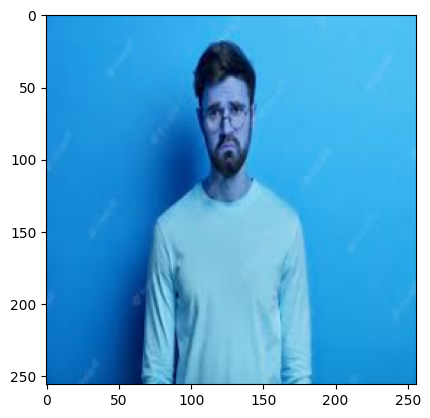

In [246]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [247]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 0s 40ms/step


array([[0.99935406]], dtype=float32)

In [248]:
if yhat > 0.5:
    print("Sad")
else:
    print("Happy")

Sad


### Save the model

In [249]:
from tensorflow.keras.models import load_model
model.save(os.path.join('models','happysadmodel.h5'))
new_model = load_model(os.path.join('models','happysadmodel.h5'))

In [244]:
yhat_new = new_model.predict(np.expand_dims(resize/255,0))
yhat_new

1/1 [==============================] - 0s 80ms/step


array([[0.98053443]], dtype=float32)

In [250]:
if yhat_new > 0.5:
    print("Sad")
else:
    print("Happy")

Sad
